先说一下ORM Entity就是一个类, 比如你有张表是users, 那你可以创建个User类, 这个类就对应那张user表, 比如下面这个Temperature类就是对应temperature表的entity, 这也是我下面讲的内容里所指的entity, 

```java
// Temperature.java
package com.choo.springdemo;

@Entity
@Table(name = "temperature")
public class Temperature {

    // Cannot use strategy = GenerationType.AUTO, otherwise won't find table
    // https://stackoverflow.com/a/49813851/16317008
    @Id
    @GeneratedValue(strategy = GenerationType.IDENTITY)
    private Integer id;
    // field name `value` same as column name in the table, so don't need to add @Column(name = "created_date") annotation
    private float value;
    @Column(name = "created_date")
    @CreationTimestamp
    private LocalDateTime createdDate;

    public Integer getId() {
        return id;
    }

    public void setId(Integer id) {
        this.id = id;
    }

    public float getValue() {
        return value;
    }
    public void setValue(float firstName) {
        this.value = firstName;
    }

    public void setCreatedDate(LocalDateTime createDate) {
        this.createdDate = createDate;
    }

    public LocalDateTime getCreatedDate() {
        return createdDate;
    }
}
```

## 1. 如何存储时间
---

记录一下今天写代码遇到的一些问题和解决办法, 

首先Spring很省事省去了那些琐碎的数据库连接关闭try catch操作, 又加上ORM JPA省去了各种SQL语句, 有时候只需要一个注解便可以解决之前是来行代码才能解决的问题, 插入和查找数据简直不要太方便. 

我有一个table叫temperature, 有三个columns, 分别是id, value和created_time(对应的entity是上面的Temperature类), 显然两个很好插入, 就是最后一个涉及到了time类型, 就比较麻烦, 在上篇文章`014 Primary Key & Timestamp`就说过, mysql的两种time相关的数据类型, 一个是`datetime`, 一个是`timestamp`, 然后我们最好选择`timestamp`来存储时间, 因为它才4字节, 而且可以存储time zone, 这很关键. 也就是说查询数据的时候, mysql会根据你的电脑的time zone来显示表里时间字段的数据值, 即自动帮你转换时间. 

然后我就发现, 原来创建表的时候可以给表的column设置默认值, 而且这个值也可以时间即通过`CURRENT_TIMESTAMP`, 来获取,类似如下:

```sql
CREATE TABLE `temperature` (
    `id` int NOT NULL AUTO_INCREMENT,
    `value` float NOT NULL,
    `created_date` timestamp NOT NULL DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP,
    PRIMARY KEY (`id`)
);
```

然后我灵机一动, 这样不就是不用我每次插入数据的时候显示插入时间了吗, 我要做的只是插入`value`, 至于`created_time`, 插入值的时候mysql就会为我自动添件本地时间了, 如下:

```java
private TemperatureRepository temperatureRepository;

@PostMapping("/add/temperature")
public String addTemperature(@RequestParam float value) {
    Temperature temperature = new Temperature();
    temperature.setValue(value);
    temperatureRepository.save(temperature);
    return "Added new temperature to repo!";
}

@GetMapping("/temperature")
public Iterable<Temperature> getTemperature() {
    return temperatureRepository.findAll();
}

// TemperatureRepository.java
public interface TemperatureRepository extends CrudRepository<Temperature, Integer> {

    Temperature findTemperatureById(Integer id);
}
```

然后问题来了, 我在上面的sql里设置的那个字段是`not null`, 所以插入数据的时候Spring报错说`created_time`不能为空, 然后我就把`created_time`字段的NOT NULL修饰删掉了, 这样就可以了吧, 我窃喜, 确实插入成功了, 但是呢, 当我查询数据的时候, 返回的json数据的`created_time`却是null, 看来是因为插入数据的时候我没指定`created_time`的值, Spring就把null作为`created_time`的值插入到表里了. 

那我再把对应这张表的ORM Entity里的`createdDate` field以及它的getter, setter删掉不就行了吗? 这样Spring就不知道表里有`created_time`这个字段了, 自然在插入数据的时候不会指定`created_time`的值, 这时候我前面设置的让mysql自动加入插入时间的操作就实现了, 不仅暗叹我真聪明. 这样确实解决了问题, 我只插入`value`就行了, 但是当我用JAVA查询数据的时候, 只返回id和value的值, 并没有返回created_time的值, 不用想, 肯定是因为我删除了ORM Entity里的`createdDate` field以及它的getter, setter. 所以`createdDate`这个field不能删, 必须保留,

删除了`createdDate` field以及它的getter, setter之后, 通过`POST http://localhost:8080/add/temperature?value=27.50`添加了一个数据, 然后分别通过sql和spring rest api查询的结果如下:

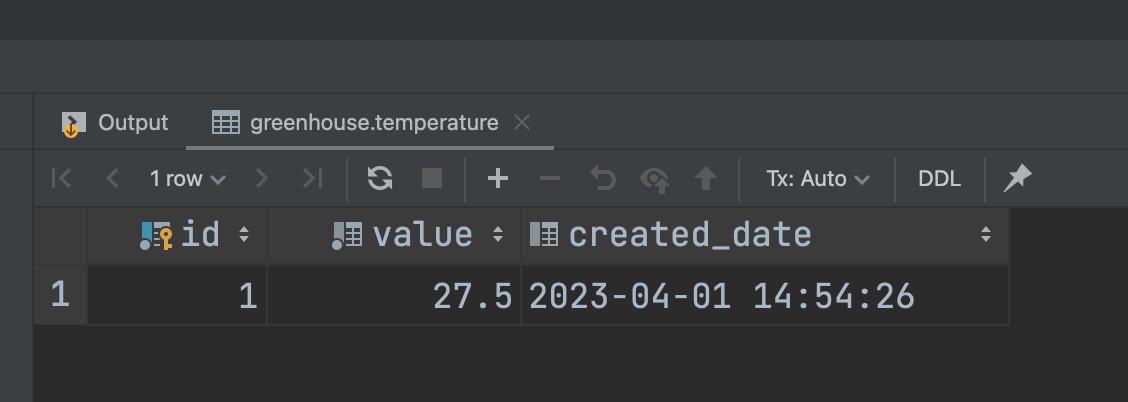

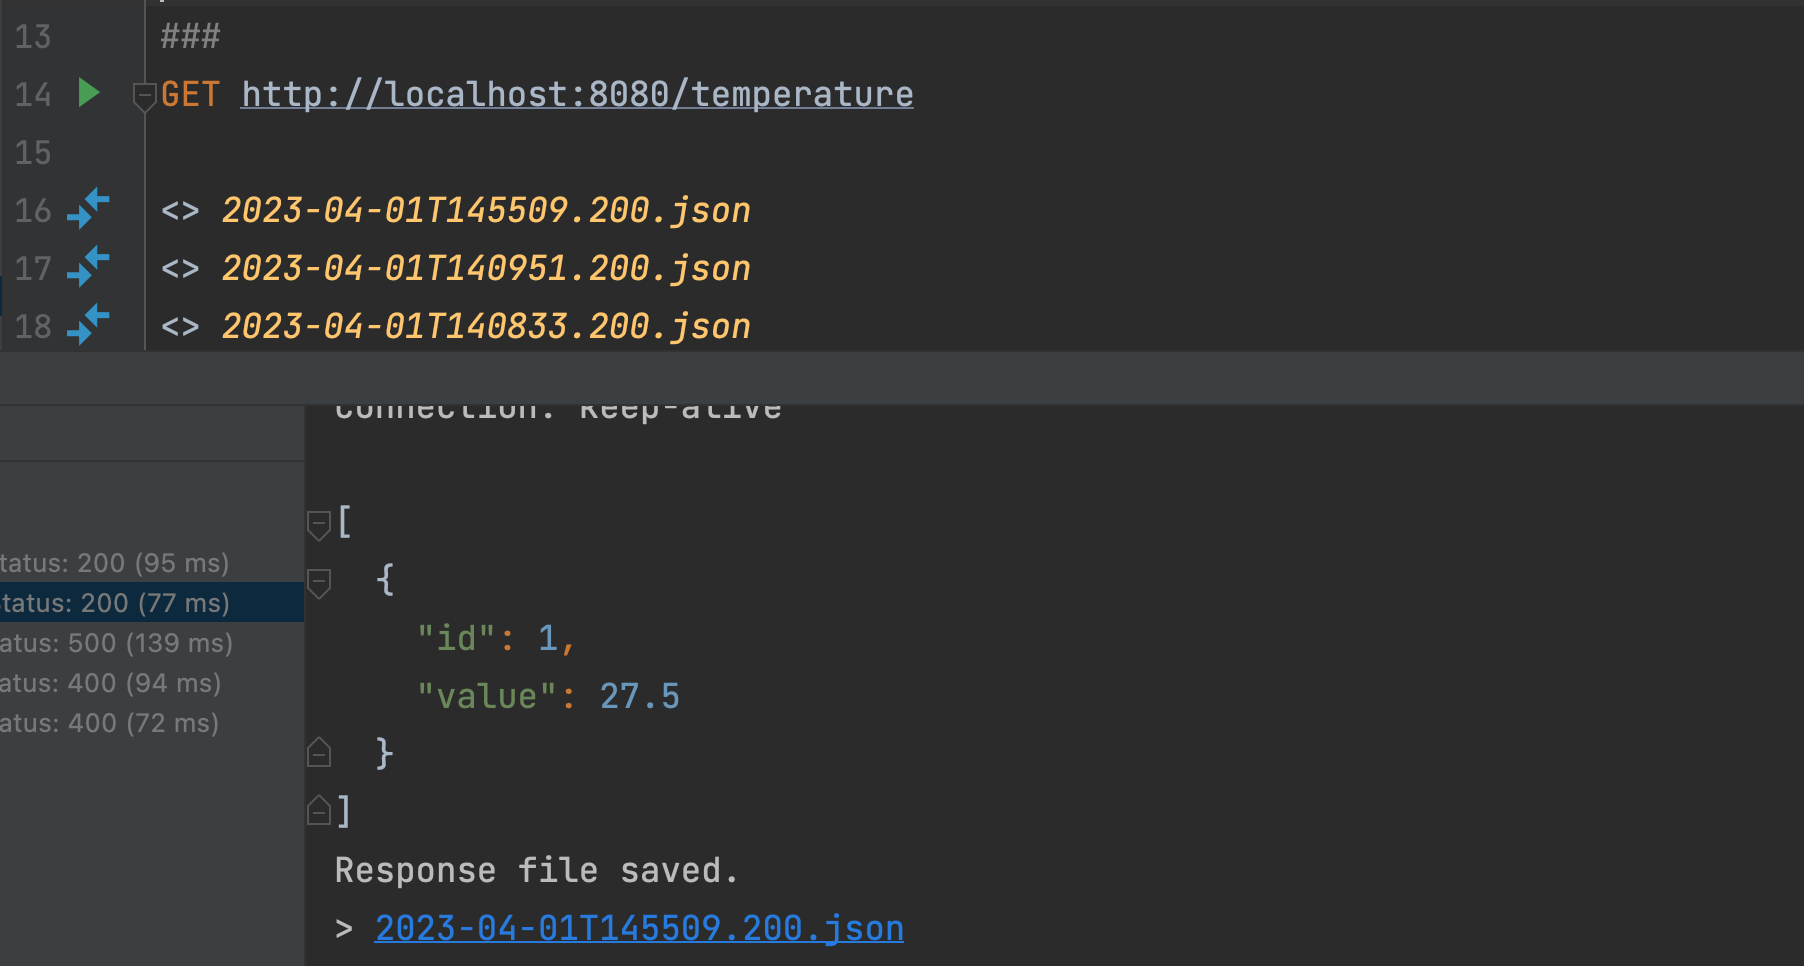

既然`createdDate`不能删除, 那我们就只能显示的在Java代码里获取时间再插入表里了, 兜兜转转又回到原地? 我不希望这样, 于是我发现, id我不是也在mysql创建并设置了自增吗? 但是id有个注解是
```java
@Id
@GeneratedValue(strategy = GenerationType.AUTO)
private Integer id;

// 在这里注意, 一般设置为@GeneratedValue(strategy = GenerationType.IDENTITY), 否则有可能spring报错找不到表greenhouse.temperature_seq, 说实话咱也不知道这个temperature_seq表是啥, 以及为啥Spring不去找greenhouse.temperature
```

所以我就想, 是不是也可以给`createdDate`字段加个类似自动生成时间的注解呢? 果然我查了到了, 像下面这样就ok了:

```java
@Column(name = "created_date")
@CreationTimestamp
private LocalDateTime createdDate;
```

当然`createdDate`的getter和setter你不能删除, 不然spring怎么帮你设置呢, 而且我们的rest api返回json数据的时候肯定也得用到getter和setter(查询数据之后数据库返回内容, 肯定得初始化Temperature对象吧然后存储每一行的值, 实体类相当于一张表, 而对象就相当于表里的每一行数据) 注解又不是魔法, 不会你真以为加个注解, 这个注解就会有种魔力直接修改createdDate的值吧? 注解只是个类似提示的东西, runtime的时候spring框架通过反射来获取每个字段的注解, 然后根据注解来做相应操作, 添加时间这些, 我们不写, 肯定是框架帮我们做了, 这样增加了代码的可读性, 不很好吗?

## 2. Spring返回时间和本机不是一个时区
----

前面我们说过, mysql表里如果要存储时间就选择`Timestamp`类型, 因为它小而且可以存储时区, 这下好了, 确实可以存储时区, 但又出现了时间与本机不一致错误, 我通过http请求获取数据库数据, 发现时间比本地早了三个小时, 如下:

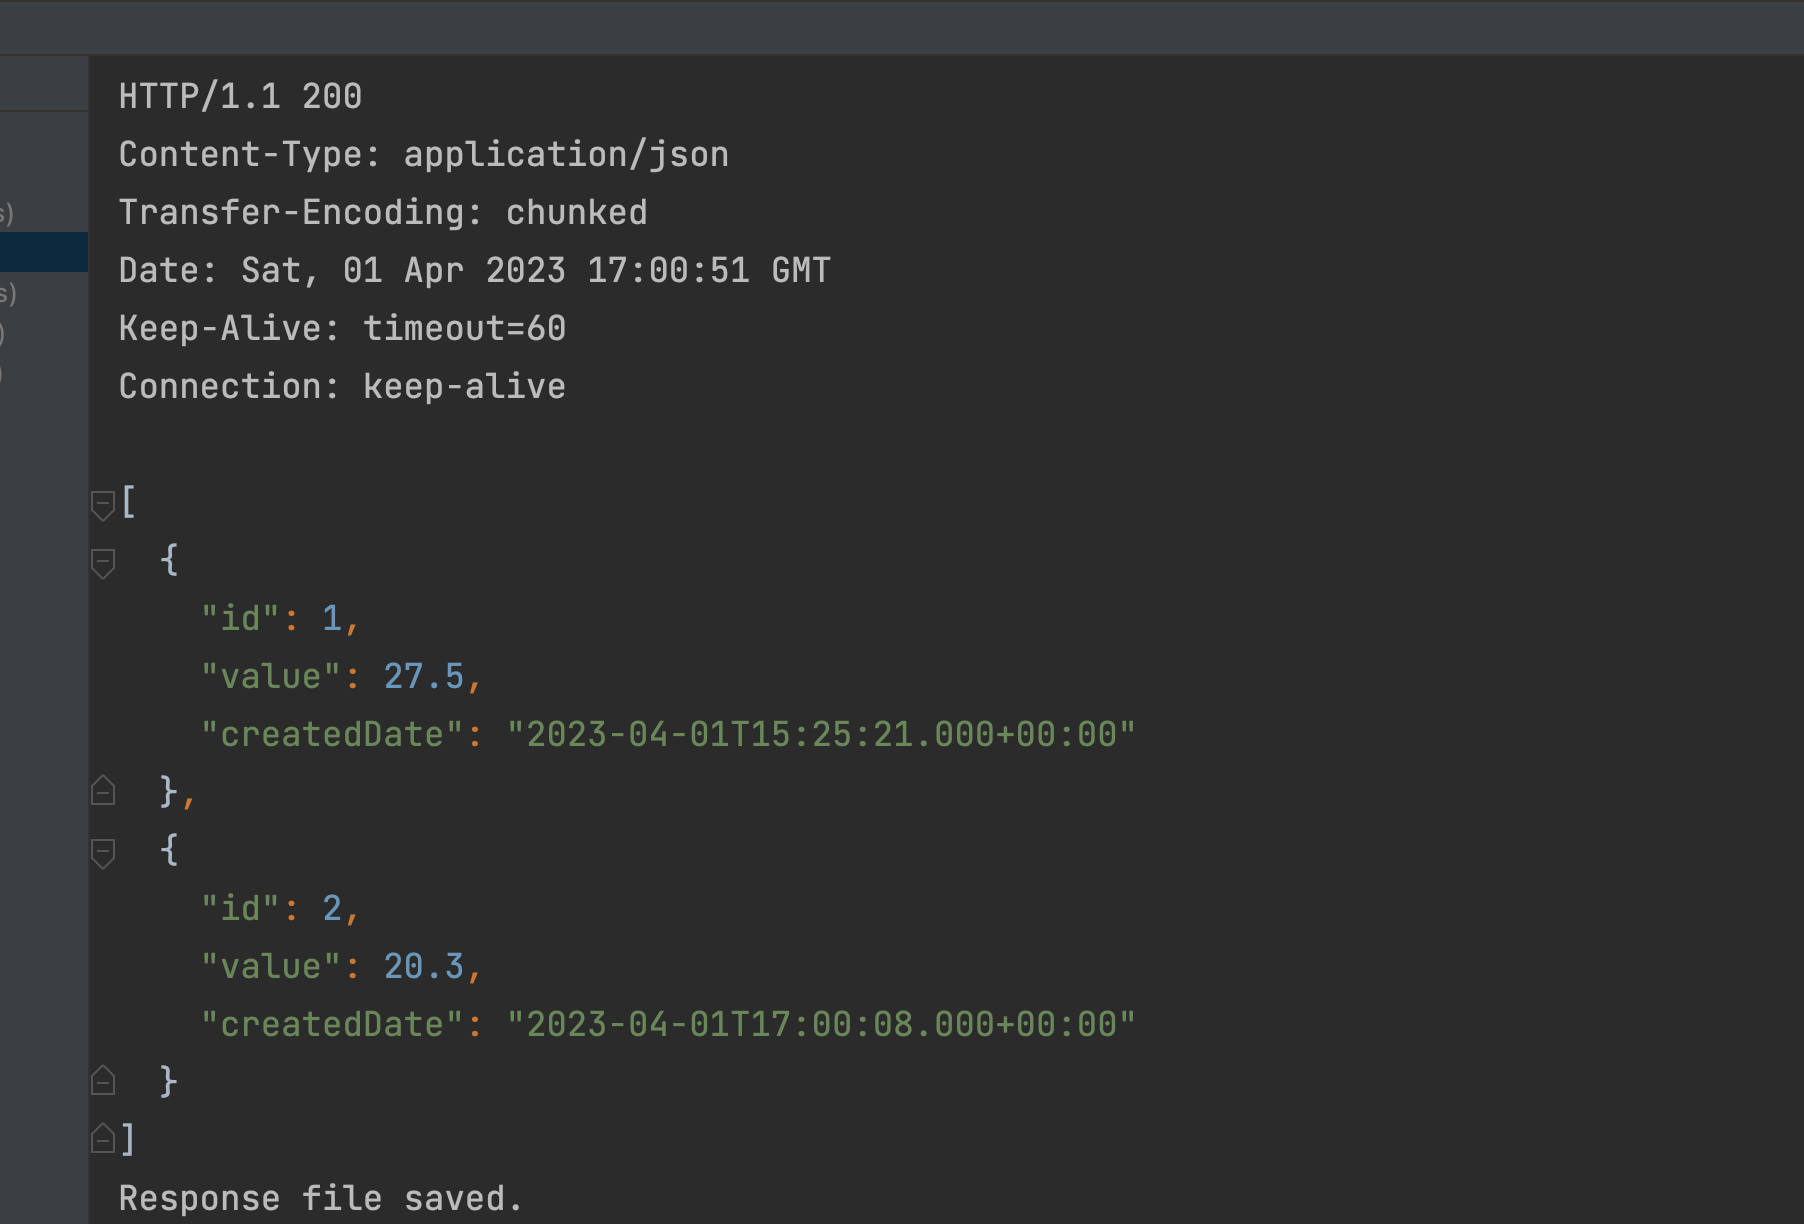

我在想这是在Spring通过上面的注解`@CreationTimestamp`自动初始化`createdDate`的时候发生的错误, 还是mysql的时区是错的呢? 然后我就看了一下mysql的时区

```sql
SELECT @@GLOBAL.time_zone;
```

这个查询的输出是SYSTEM, 所以mysql时区没错, 但我还不相信, 就查了一下数据, 发现数据的时间确实是我添加的时间, 并没有错, 这就说明是我Java代码除了问题, 如下图(可以看出查询的时间和上买呢json是不一样的):

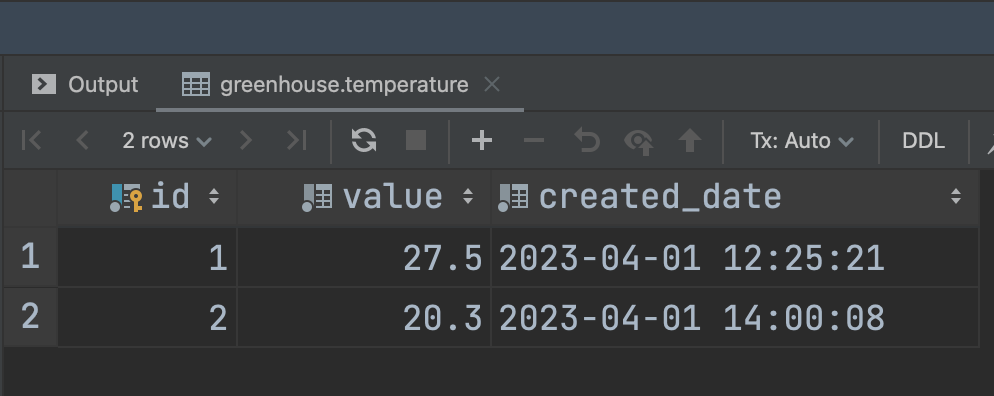

解决办法就是如果你的数据库表里有`Timestamp`类型的数据, 那在创建对应实体类的时候要使用`LocalDateTime`来定义对应的字段, 而不是使用`java.util.Date`来指定, 具体代码可以参考文章最前面`Temperature`类的`createdDate`字段是如何定义的. 